# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import statsmodels.api as sm 
import sklearn


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler,PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kendalltau, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


# Functions

In [2]:
''' We got many null values from scraping so this function will convert null value to Nan values '''

def convert_to_nans(data):
    for i in range(len(data.columns)):
        data.loc[data.iloc[:, i] == "Null", data.columns[i]] = np.nan

In [3]:
# drop_outliers Function with quantiles (25, 75) 
def drop_outliers_for_categorical(df):
    IQR = 0
    
    q1 = df["prices"].quantile(.01)
    q3 = df["prices"].quantile(.99)
    
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR

    
    data_without_outliers = df.drop(df[((df["prices"] > upper) | (df["prices"] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)
    
#     print(f"Q1 = {q1}" + " " + f"Q3 = {q3}")
    return data_without_outliers


In [4]:
# drop_outliers Function with quantiles (25, 75) 
def drop_outliers_for_numerical(df, col):
    IQR = 0
    
    q1 = df[col].quantile(.01)
    q3 = df[col].quantile(.99)
    
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR

    
    data_without_outliers = df.drop(df[((df[col] > upper) | (df[col] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)
    
    
#     print(f"Q1 = {q1}" + " " + f"Q3 = {q3}")
    return data_without_outliers


# Load Our Scrapped Data

In [5]:
data = pd.read_csv("final_buy.csv")
data.drop(columns=["Unnamed: 0", "links", 'Type'], inplace = True)
data.reset_index(drop= True, inplace=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo / Arabesque Compound - SED,"3,600,000 EGP","- 24,827 EGP/m",145 m²,3 rooms,3 bathroom,Extra Super Lux,Garden,3,2025,Cash
1,Greater Cairo / Isola Sheraton Compound - El...,"9,500,000 EGP","- 54,285 EGP/m",175 m²,3 rooms,3 bathroom,Semi Finished,Main Street,4,2026,Cash or Installments
2,North Coast / Waterway Resort,"34,636,000 EGP","- 193,497 EGP/m",179 M²,Null,Null,Extra super lux,Seaview,Null,2027,Cash or Installments
3,Greater Cairo / Hyde Park Compound,"126,800,000 EGP","- 184,839 EGP/m",Null,Null,Null,Null,Null,Null,Null,Null
4,Greater Cairo / Scenario Compound - Akam,"7,735,919 EGP","- 51,231 EGP/m",Null,Null,Null,Null,Null,Null,Null,Null
...,...,...,...,...,...,...,...,...,...,...,...
302995,Greater Cairo / Hadayek El Zayton,"1,500,000 EGP","- 12,500 EGP/m",120 m²,3 rooms,1 bathroom,Super Lux,Other,8,2016,Cash
302996,Alexandria / El Falki,"770,000 EGP","- 8,555 EGP/m",90 m²,2 rooms,1 bathroom,Super Lux,Other,8,2021,Cash
302997,Alexandria / Omar Ibn El-Khattab St,"220,000 EGP","- 2,750 EGP/m",80 m²,2 rooms,1 bathroom,Super Lux,Other,3,2017,Cash
302998,Alexandria / El Mandara,"4,500,000 EGP","- 20,454 EGP/m",220 m²,3 rooms,2 bathroom,Super Lux,Other,9,2010,Cash


# Data Cleaning

In [6]:
## Remove Rows with no Details

data.drop(data[(data.iloc[:,3:] == "Null").all(axis=1)].index, axis=0, inplace=True)
data.reset_index(drop= True, inplace=True)

In [7]:
## Convert all Nulls To NaNs
convert_to_nans(data)

In [8]:
## Split columns 

location_data = pd.DataFrame(data= data["locations"].str.split('/', expand= True))[0].str.strip()
price_data = pd.DataFrame(data= data["prices"].str.split(' ', expand= True))[0].str.strip()
priceperm_data = pd.DataFrame(data= data["Price_per_m"].str.split(' ', expand= True))[1].str.strip()
size_data = pd.DataFrame(data= data["sizes"].str.split(' ', expand= True))[0].str.strip()
room_data = pd.DataFrame(data= data["rooms"].str.split(' ', expand= True))[0].str.strip()
bathroom_data = pd.DataFrame(data= data["bathrooms"].str.split(' ', expand= True))[0].str.strip()


data.iloc[:,0] = location_data
data.iloc[:,1] = price_data.str.replace(",", "").astype(float)
data.iloc[:,2] = priceperm_data.str.replace(",", "").astype(float)
data.iloc[:,3] = size_data.astype(float)
data.iloc[:,4] = room_data.astype(float)
data.iloc[:,5] = bathroom_data.astype(float)
data.iloc[:,9] = data["years"].astype(float)

data.reset_index(drop= True, inplace=True)

### Data after Splitting
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,NaN,NaN,Extra super lux,Seaview,NaN,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,NaN,Without Finish,Main Street,3,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299046,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8,2016.0,Cash
299047,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8,2021.0,Cash
299048,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3,2017.0,Cash
299049,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9,2010.0,Cash


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299051 entries, 0 to 299050
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299051 non-null  object 
 1   prices       299051 non-null  float64
 2   Price_per_m  299031 non-null  float64
 3   sizes        299051 non-null  float64
 4   rooms        264515 non-null  float64
 5   bathrooms    261603 non-null  float64
 6   finishes     281836 non-null  object 
 7   views        291588 non-null  object 
 8   floors       252943 non-null  object 
 9   years        283140 non-null  float64
 10  payments     297931 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


In [10]:
data.describe()

,prices,Price_per_m,sizes,rooms,bathrooms,years
count,2.990510e+05,2.990310e+05,2.990510e+05,264515.000000,261603.000000,283140.000000
mean,7.671305e+06,3.284128e+04,1.281021e+04,2.827360,1.785427,2018.808155
std,3.899018e+08,1.353851e+05,3.299348e+06,2.879965,1.451718,49.055329
min,1.000000e+04,0.000000e+00,4.000000e+00,0.000000,0.000000,202.000000
25%,8.500000e+05,7.307000e+03,1.000000e+02,2.000000,1.000000,2017.000000
50%,2.000000e+06,1.419300e+04,1.300000e+02,3.000000,1.000000,2020.000000
75%,6.052000e+06,3.917950e+04,1.750000e+02,3.000000,2.000000,2024.000000
max,2.100000e+11,6.905830e+07,1.260000e+09,858.000000,200.000000,20284.000000


### Imputing NaNs

###### Price Per Meter Square

In [11]:
## Impute NaNs in price per m column using size and prices
data.loc[data["Price_per_m"].isna(), "Price_per_m"] = data["prices"] / data["sizes"]

## Remove Not correct price per meter square
data.drop(data[~(data["Price_per_m"] - data["prices"] / data["sizes"]<100)].index, inplace= True, axis= 0)
data.reset_index(drop= True, inplace= True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        264493 non-null  float64
 5   bathrooms    261581 non-null  float64
 6   finishes     281813 non-null  object 
 7   views        291548 non-null  object 
 8   floors       252921 non-null  object 
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


# Encoding

###### Locations

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


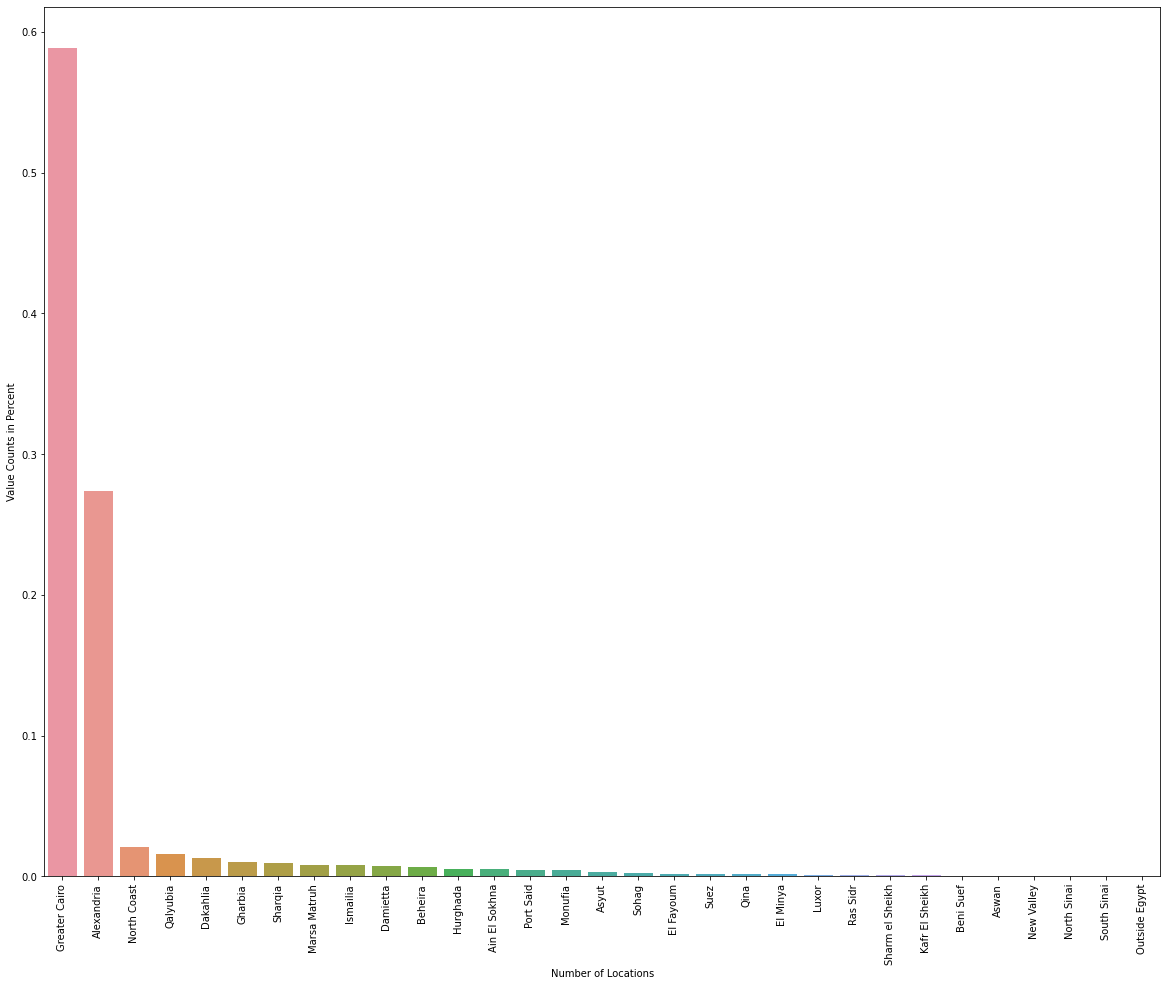

In [13]:
location = data["locations"].value_counts(normalize= True)


plt.figure(figsize=(20,16))
sns.barplot(location.index, location.values)
plt.xlabel("Number of Locations")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [14]:
# Slice Non Cairo And Alexandria Properties

not_valid_location = data[~((data["locations"] == "Alexandria") | (data["locations"] == "Greater Cairo") | (data["locations"] == "North Coast"))]

## Convert any other locations to 0 value
data.loc[not_valid_location.index, "locations"] = "other"

## Encode other locations
data["locations"].replace("other", 1, inplace= True)
data["locations"].replace("Greater Cairo", 2, inplace= True)
data["locations"].replace("Alexandria", 3, inplace= True)
data["locations"].replace("North Coast", 4, inplace= True)



C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


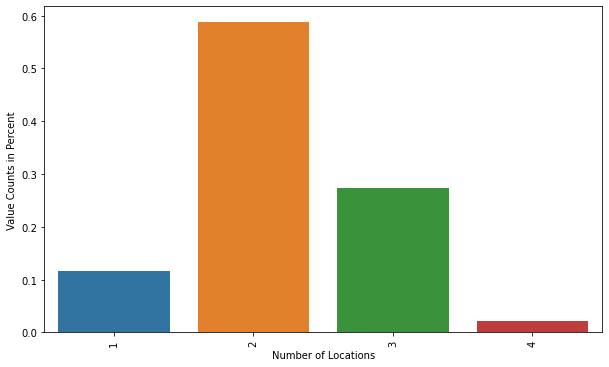

In [15]:
location = data["locations"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(location.index, location.values)
plt.xlabel("Number of Locations")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

###### Rooms

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


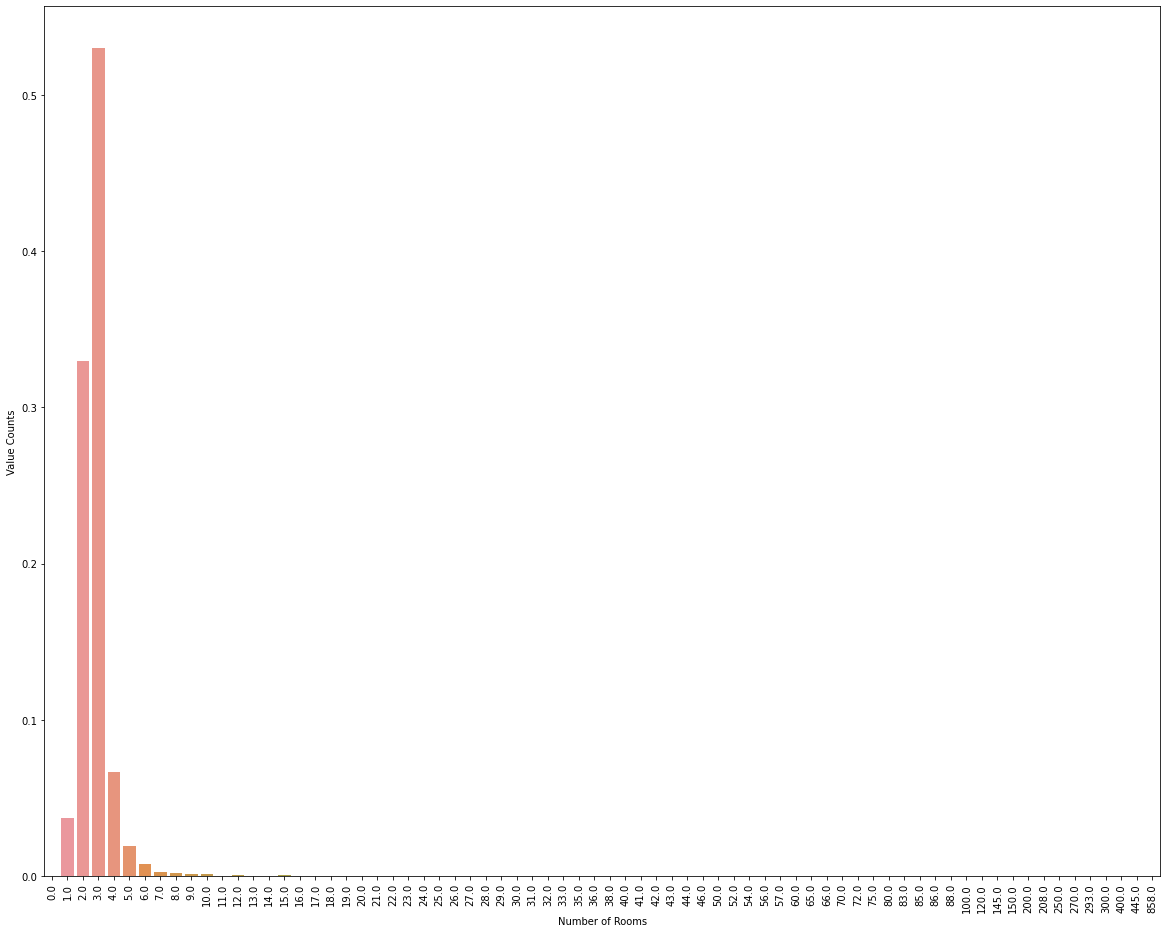

In [16]:
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Rooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [17]:
## Took Categories fron 1 to 5 only
data.drop(data[~((data["rooms"] < 6) & (data["rooms"] >0))].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


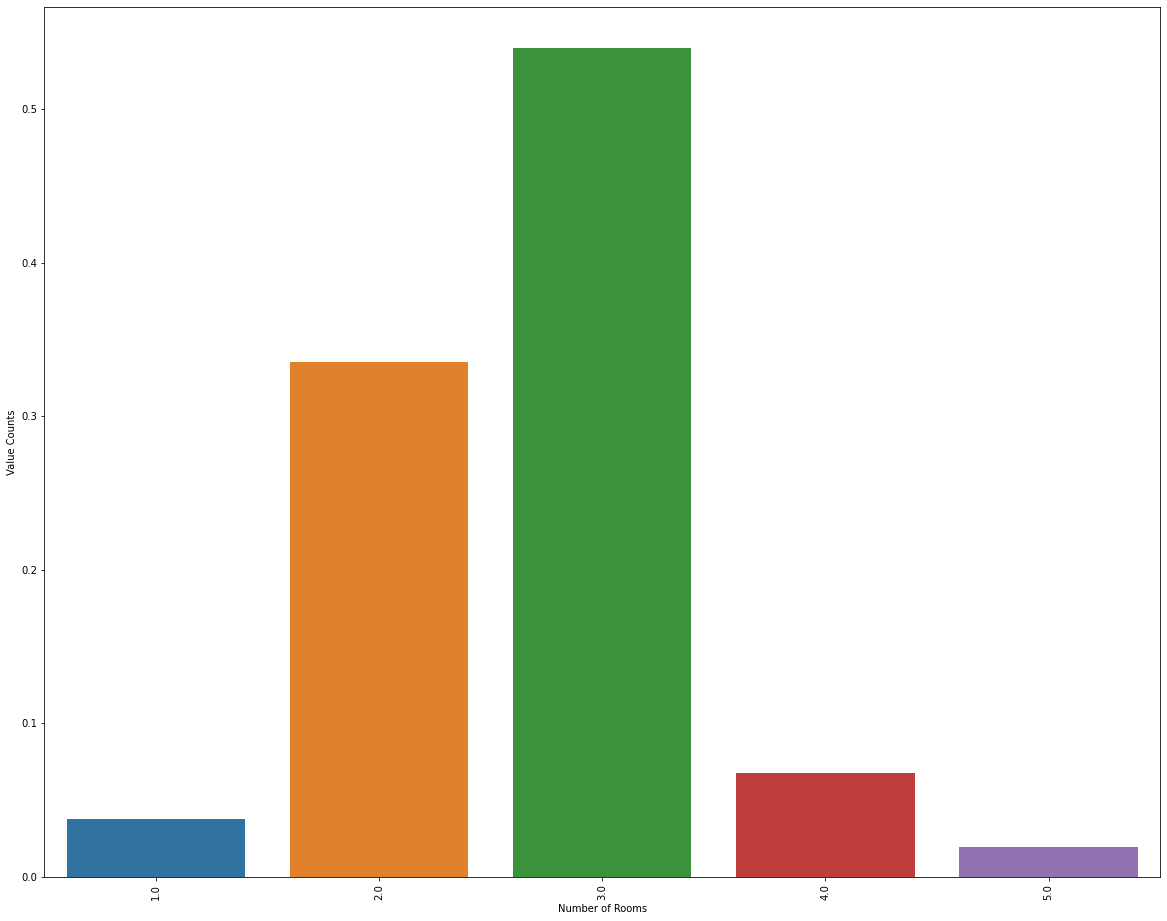

In [18]:
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Rooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

###### Bathrooms

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


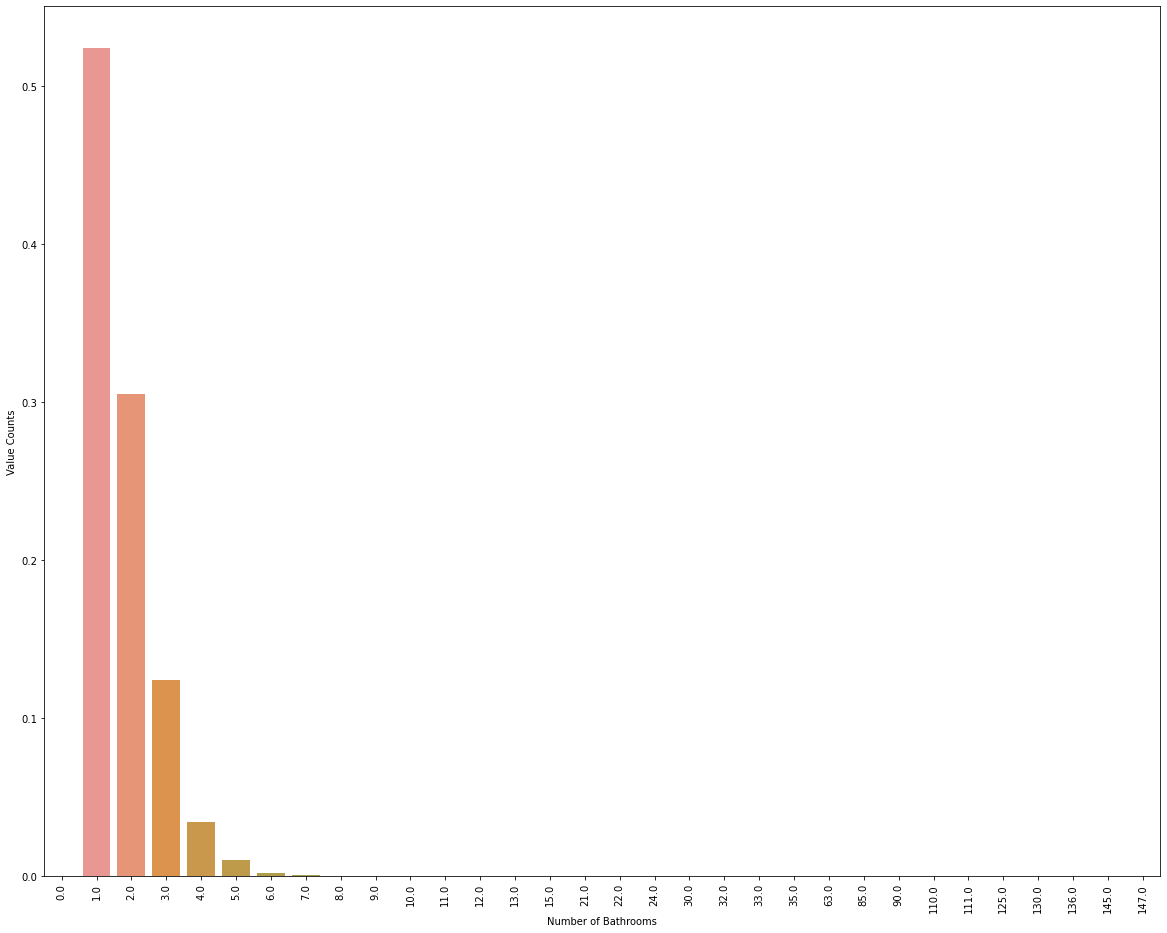

In [19]:
room = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Bathrooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [20]:
## Took Categories fron 1 to 5 only
data.drop(data[~((data["bathrooms"] < 6) & (data["bathrooms"] >0))].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


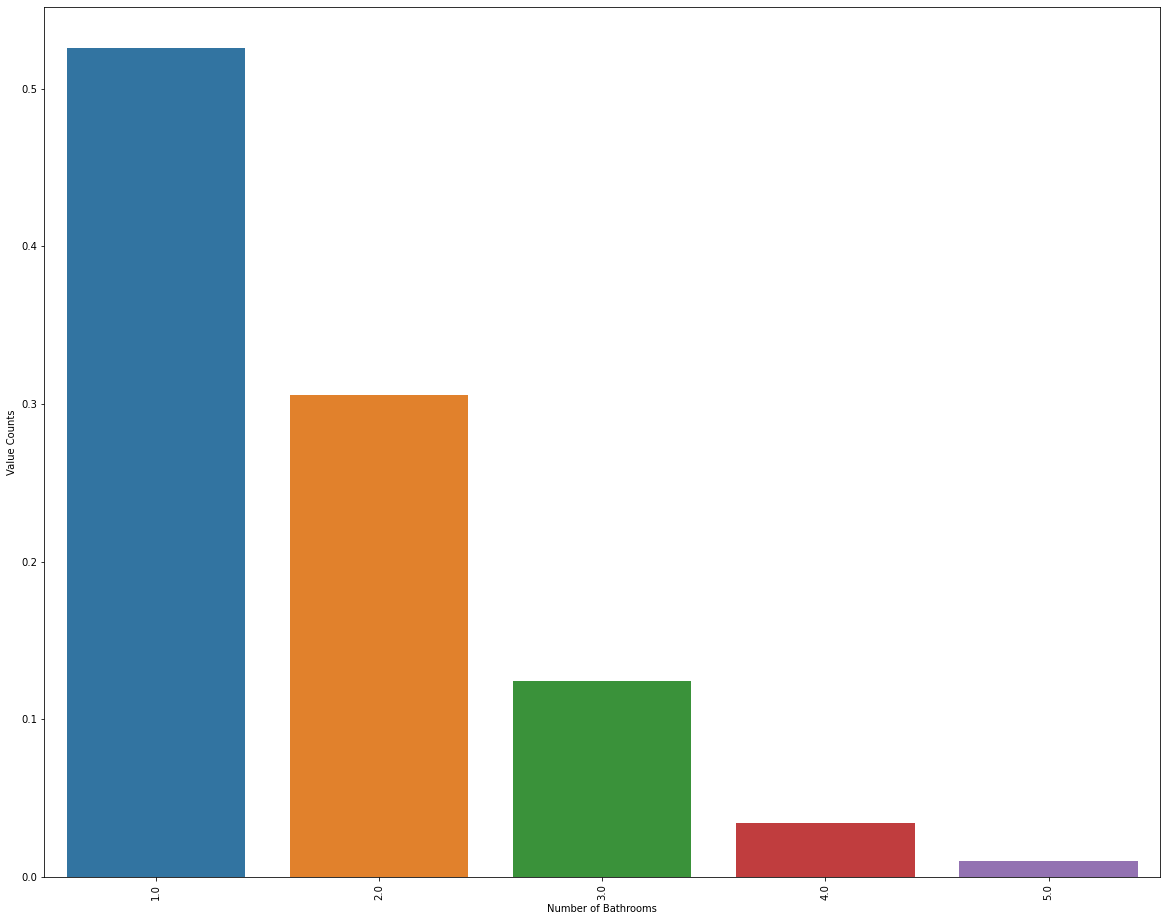

In [21]:
room = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Bathrooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

###### Floors

In [22]:
## convert ground floor to value 0
data.loc[data["floors"]== "Ground", "floors"] = 0

In [23]:
data["floors"].replace('12,13', np.nan, inplace= True)
data["floors"].replace('9,10', np.nan, inplace= True)
data["floors"].replace('5.6', np.nan, inplace= True)

data["floors"] = data["floors"].astype(float)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


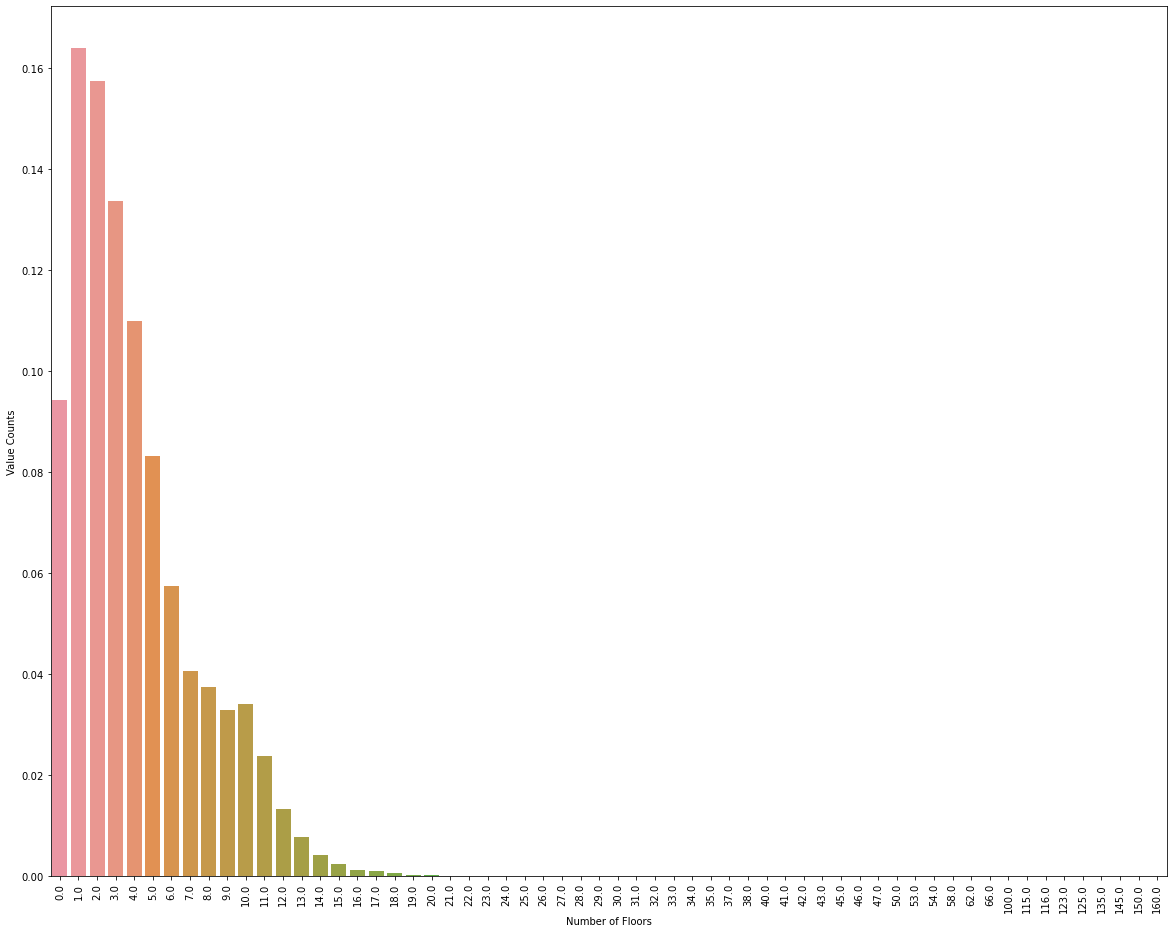

In [24]:
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,16))
sns.barplot(floor.index, floor.values)
plt.xlabel("Number of Floors")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [25]:
## Took Categories fron 0 to 10 only
data.drop(data[~(data["floors"] < 11)].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


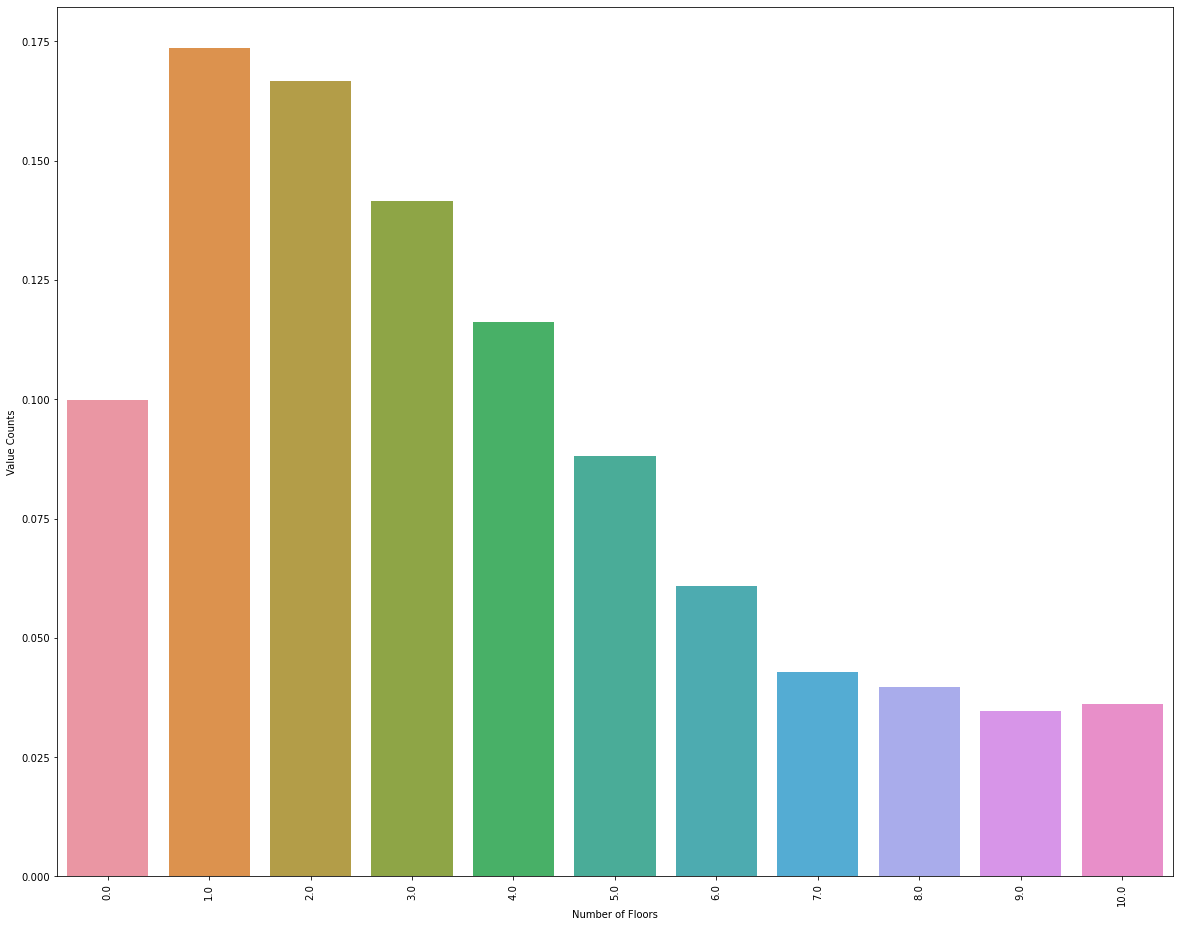

In [26]:
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,16))
sns.barplot(floor.index, floor.values)
plt.xlabel("Number of Floors")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

###### Finishes

In [27]:
## Encoding Finish Type

data["finishes"].replace('Without Finish', 1, inplace= True)
data["finishes"].replace('Semi Finished', 2, inplace= True)
data["finishes"].replace('Lux', 3, inplace= True)
data["finishes"].replace('Super Lux', 4, inplace= True)
data["finishes"].replace('Extra Super Lux', 5, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


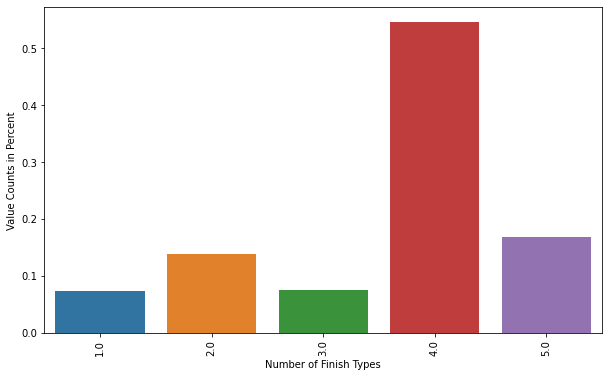

In [28]:
finish = data["finishes"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(finish.index, finish.values)
plt.xlabel("Number of Finish Types")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223984 entries, 0 to 223983
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    223984 non-null  int64  
 1   prices       223984 non-null  float64
 2   Price_per_m  223984 non-null  float64
 3   sizes        223984 non-null  float64
 4   rooms        223984 non-null  float64
 5   bathrooms    223984 non-null  float64
 6   finishes     223983 non-null  float64
 7   views        218787 non-null  object 
 8   floors       223984 non-null  float64
 9   years        223979 non-null  float64
 10  payments     223272 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 18.8+ MB


###### Views

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


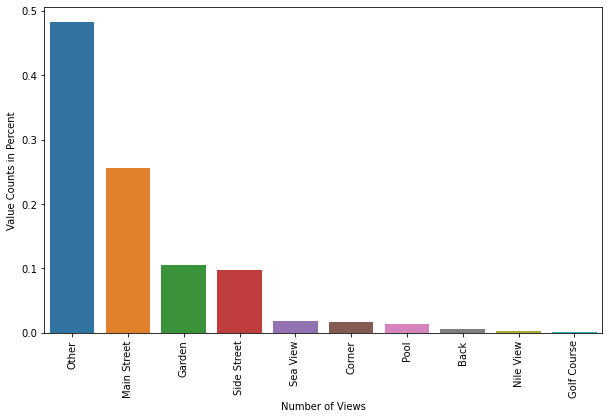

In [30]:
View = data["views"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(View.index, View.values)
plt.xlabel("Number of Views")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [31]:
## I will take first 7 categories only and convert others
high_view_cat = data["views"].value_counts()[:7].index
high_view_cat

## convert some views to Other
data.loc[~(data["views"].isin(high_view_cat)), "views"] = "Other"

In [32]:
data["views"].replace('Corner', 1, inplace= True)
data["views"].replace('Garden', 2, inplace= True)
data["views"].replace('Main Street', 3, inplace= True)
data["views"].replace('Other', 4, inplace= True)
data["views"].replace('Pool', 5, inplace= True)
data["views"].replace('Sea View', 6, inplace= True)
data["views"].replace('Side Street', 7, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


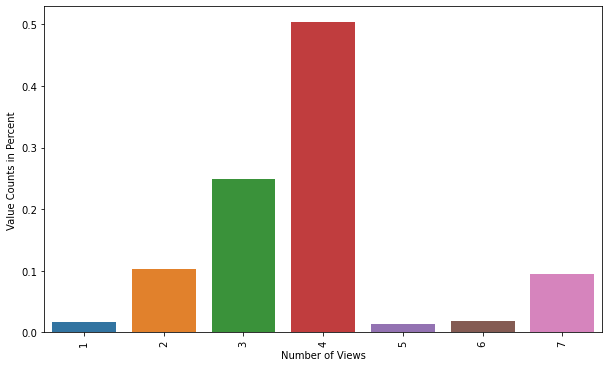

In [33]:
View = data["views"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(View.index, View.values)
plt.xlabel("Number of Views")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

###### Payment

In [34]:
data["payments"].replace('Cash', 1, inplace= True)
data["payments"].replace('Cash or Installments', 2, inplace= True)
data["payments"].replace('Installments', 3, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


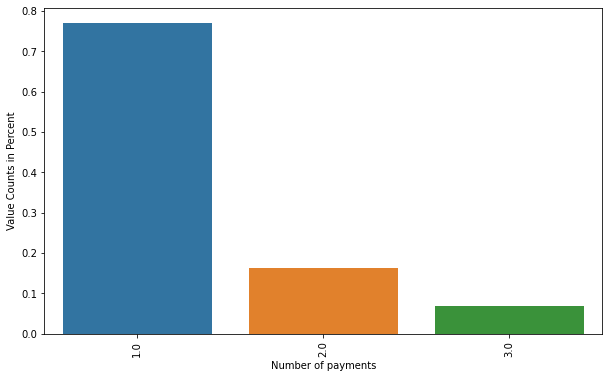

In [35]:
payment = data["payments"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(payment.index, payment.values)
plt.xlabel("Number of payments")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

### Dealing With Outliers

"" Main idea of handling OUTLIERS ""


    Numerical : check if this element is outlier in Numerical Column and Target column (Prices)
    Categorical : check Outlliers in each category based on Target Column (prices)

In [36]:
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,3600000.0,24827.0,145.0,3.0,3.0,5.0,2,3.0,2025.0,1.0
1,2,9500000.0,54285.0,175.0,3.0,3.0,2.0,3,4.0,2026.0,2.0
2,2,5125000.0,35344.0,145.0,3.0,2.0,5.0,2,2.0,2023.0,2.0
3,4,7100000.0,48965.0,145.0,2.0,2.0,5.0,6,2.0,2025.0,3.0
4,2,9700000.0,75781.0,128.0,2.0,2.0,1.0,3,2.0,2026.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
223979,2,1500000.0,12500.0,120.0,3.0,1.0,4.0,4,8.0,2016.0,1.0
223980,3,770000.0,8555.0,90.0,2.0,1.0,4.0,4,8.0,2021.0,1.0
223981,3,220000.0,2750.0,80.0,2.0,1.0,4.0,4,3.0,2017.0,1.0
223982,3,4500000.0,20454.0,220.0,3.0,2.0,4.0,4,9.0,2010.0,1.0


In [37]:
## Handling Types of our features

data.iloc[:,1] = data.iloc[:,1].astype(float)
data.iloc[:,2] = data.iloc[:,2].astype(float)
data.iloc[:,3] = data.iloc[:,3].astype(int)
data.iloc[:,4] = data.iloc[:,4].astype(int)
data.iloc[:,5] = data.iloc[:,5].astype(int)
data.iloc[:,8] = data.iloc[:,8].astype(int)
data.iloc[:,9] = data.iloc[:,9].astype(float)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223984 entries, 0 to 223983
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    223984 non-null  int64  
 1   prices       223984 non-null  float64
 2   Price_per_m  223984 non-null  float64
 3   sizes        223984 non-null  int32  
 4   rooms        223984 non-null  int32  
 5   bathrooms    223984 non-null  int32  
 6   finishes     223983 non-null  float64
 7   views        223984 non-null  int64  
 8   floors       223984 non-null  int32  
 9   years        223979 non-null  float64
 10  payments     223272 non-null  float64
dtypes: float64(5), int32(4), int64(2)
memory usage: 15.4 MB


###### Views

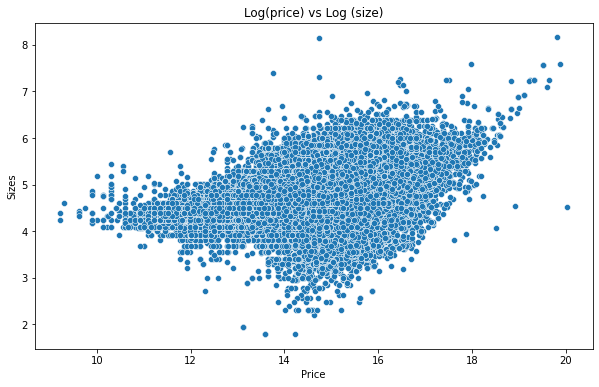

In [39]:
plt.figure(figsize=(10,6))
plt.title("Log(price) vs Log (size)")

sns.scatterplot(x= np.log(data["prices"]), y= np.log(data["sizes"]))

plt.xlabel("Price")
plt.ylabel("Sizes")

plt.show()

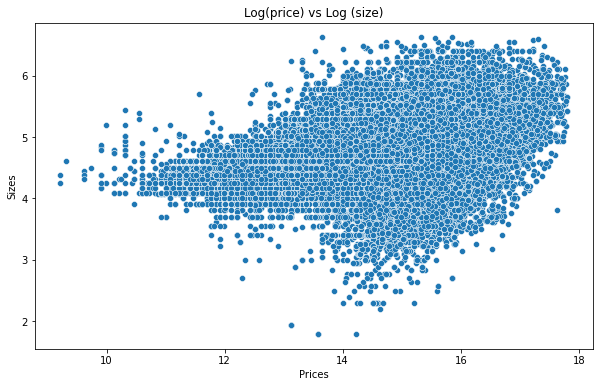

In [40]:
data_without_outliers = drop_outliers_for_numerical(data, "prices")
data_without_outliers = drop_outliers_for_numerical(data_without_outliers, "sizes")

plt.figure(figsize=(10,6))
plt.title("Log(price) vs Log (size)")
sns.scatterplot(x= np.log(data_without_outliers["prices"]), y= np.log(data_without_outliers["sizes"]))

plt.xlabel("Prices")
plt.ylabel("Sizes")

plt.show()

In [41]:
data_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223749 entries, 0 to 223748
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    223749 non-null  int64  
 1   prices       223749 non-null  float64
 2   Price_per_m  223749 non-null  float64
 3   sizes        223749 non-null  int32  
 4   rooms        223749 non-null  int32  
 5   bathrooms    223749 non-null  int32  
 6   finishes     223748 non-null  float64
 7   views        223749 non-null  int64  
 8   floors       223749 non-null  int32  
 9   years        223744 non-null  float64
 10  payments     223040 non-null  float64
dtypes: float64(5), int32(4), int64(2)
memory usage: 15.4 MB


###### Rooms TT

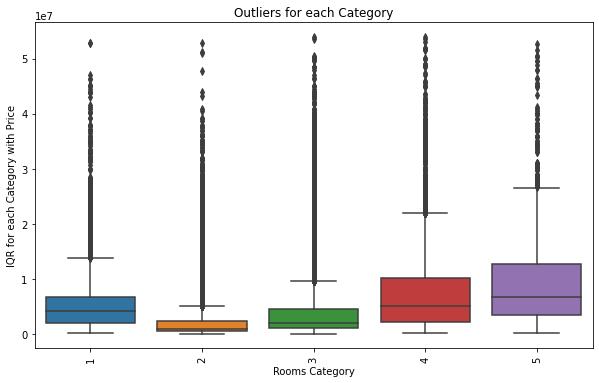

In [42]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["rooms"], y= data_without_outliers["prices"])

plt.xlabel("Rooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

In [43]:
data_without_outliers = data_without_outliers.groupby("rooms").apply(drop_outliers_for_categorical)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0
1,4,3000000.0,33707.0,89,1,1,5.0,6,2,2025.0,2.0
2,2,7310000.0,83068.0,88,1,2,2.0,2,1,2024.0,3.0
3,4,900000.0,22500.0,40,1,1,5.0,5,1,2025.0,3.0
4,2,3000000.0,142857.0,21,1,1,5.0,3,3,2025.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
223734,3,1250000.0,4464.0,280,5,3,4.0,4,2,2022.0,1.0
223735,3,790000.0,3950.0,200,5,2,4.0,4,0,2009.0,1.0
223736,2,5000000.0,17857.0,280,5,3,4.0,3,0,2020.0,1.0
223737,3,2500000.0,3846.0,650,5,3,4.0,4,9,2007.0,1.0


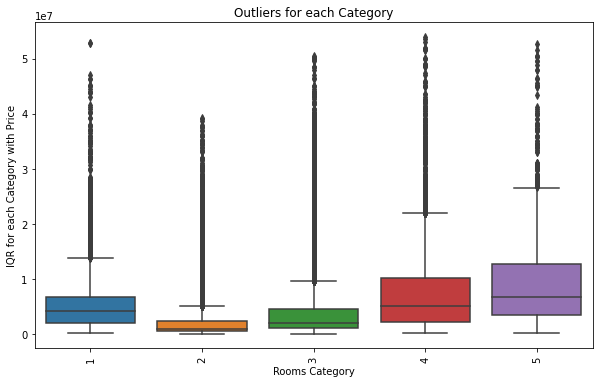

In [44]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["rooms"], y= data_without_outliers["prices"])

plt.xlabel("Rooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Bathrooms TT

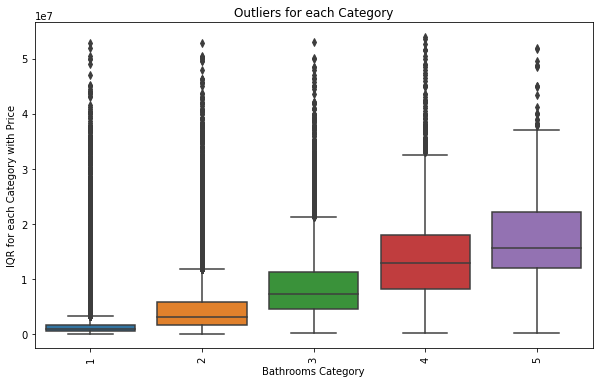

In [45]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["bathrooms"], y= data_without_outliers["prices"])

plt.xlabel("Bathrooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

In [46]:
data_without_outliers = data_without_outliers.groupby("bathrooms").apply(drop_outliers_for_categorical)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0
1,4,3000000.0,33707.0,89,1,1,5.0,6,2,2025.0,2.0
2,4,900000.0,22500.0,40,1,1,5.0,5,1,2025.0,3.0
3,2,3000000.0,142857.0,21,1,1,5.0,3,3,2025.0,3.0
4,2,11736515.0,138076.0,85,1,1,2.0,2,0,2026.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
223605,2,14500000.0,46774.0,310,5,5,4.0,7,8,2019.0,1.0
223606,2,11000000.0,20000.0,550,5,5,4.0,4,1,2020.0,1.0
223607,3,27500000.0,70512.0,390,5,5,5.0,6,6,2021.0,1.0
223608,3,27500000.0,70512.0,390,5,5,5.0,6,1,2021.0,1.0


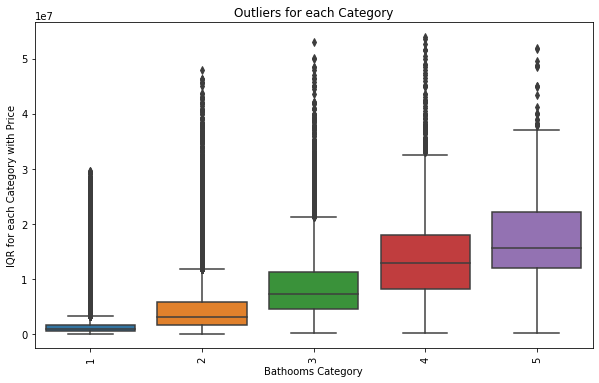

In [47]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["bathrooms"], y= data_without_outliers["prices"])

plt.xlabel("Bathooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Floors TT

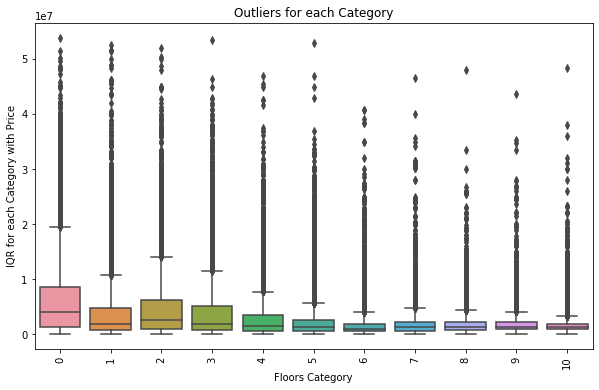

In [48]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["floors"], y= data_without_outliers["prices"])

plt.xlabel("Floors Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

In [49]:
data_without_outliers = data_without_outliers.groupby("floors").apply(drop_outliers_for_categorical)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0
1,2,11736515.0,138076.0,85,1,1,2.0,2,0,2026.0,2.0
2,1,5250000.0,95454.0,55,1,1,5.0,3,0,2025.0,2.0
3,1,1100000.0,18333.0,60,1,1,1.0,7,0,2024.0,1.0
4,2,3200000.0,50000.0,64,1,1,2.0,2,0,2025.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
223579,3,17500000.0,53030.0,330,4,5,4.0,4,10,2004.0,1.0
223580,2,9000000.0,18000.0,500,5,5,4.0,4,10,2021.0,1.0
223581,2,7500000.0,17857.0,420,5,5,3.0,3,10,2000.0,1.0
223582,2,30000000.0,82191.0,365,5,5,5.0,4,10,2018.0,2.0


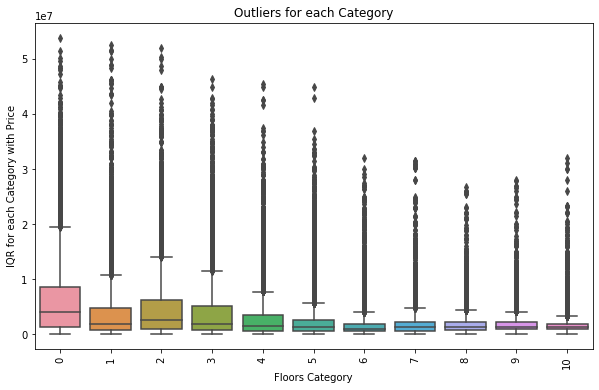

In [50]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["floors"], y= data_without_outliers["prices"])

plt.xlabel("Floors Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Years

In [51]:
data_without_outliers["property_age"] = 2024 - data_without_outliers["years"]
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0,-3.0
1,2,11736515.0,138076.0,85,1,1,2.0,2,0,2026.0,2.0,-2.0
2,1,5250000.0,95454.0,55,1,1,5.0,3,0,2025.0,2.0,-1.0
3,1,1100000.0,18333.0,60,1,1,1.0,7,0,2024.0,1.0,0.0
4,2,3200000.0,50000.0,64,1,1,2.0,2,0,2025.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
223579,3,17500000.0,53030.0,330,4,5,4.0,4,10,2004.0,1.0,20.0
223580,2,9000000.0,18000.0,500,5,5,4.0,4,10,2021.0,1.0,3.0
223581,2,7500000.0,17857.0,420,5,5,3.0,3,10,2000.0,1.0,24.0
223582,2,30000000.0,82191.0,365,5,5,5.0,4,10,2018.0,2.0,6.0


###### Drop Sizes

In [52]:
# Drop prices per square meter column and let Size Column
data_without_outliers.drop(columns=["sizes"], inplace= True, axis=1)
# data_without_outliers.drop(columns=["years"], inplace= True, axis=1)

data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
223579,3,17500000.0,53030.0,4,5,4.0,4,10,2004.0,1.0,20.0
223580,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0
223581,2,7500000.0,17857.0,5,5,3.0,3,10,2000.0,1.0,24.0
223582,2,30000000.0,82191.0,5,5,5.0,4,10,2018.0,2.0,6.0


In [108]:
inflation = pd.DataFrame()
inflation_rate = pd.read_excel("Inflations Historical.xlsx", header=1)
inflation_rate = inflation_rate.iloc[0:241:]
inflation_rate

,Date,Headline (y/y),Core (y/y),Regulated Items (y/y),Fruits and Vegetables (y/y)
0,Jan 2025,23.950%,22.590%,29.890%,20.890%
1,Dec 2024,24.060%,23.220%,31.250%,11.830%
2,Nov 2024,25.540%,23.710%,30.750%,30.000%
3,Oct 2024,26.531%,24.404%,31.810%,34.190%
4,Sep 2024,26.397%,24.966%,30.242%,30.290%
...,...,...,...,...,...
236,May 2005,5.081%,4.103%,7.638%,5.672%
237,Apr 2005,4.604%,4.530%,7.546%,-2.573%
238,Mar 2005,5.527%,5.995%,7.637%,-3.476%
239,Feb 2005,6.729%,6.144%,10.852%,0.014%


In [109]:
inflation["date_inflation"] = inflation_rate["Date"].str.split(" ", expand= True)[1]
inflation["headline_inflation"] = inflation_rate["Headline (y/y)"].str.split("%", expand= True)[0]
inflation["core_inflation"] = inflation_rate["Core (y/y)"].str.split("%", expand= True)[0]
inflation["regulated_inflation"] = inflation_rate["Regulated Items (y/y)"].str.split("%", expand= True)[0]
inflation["f_v_inflation"] = inflation_rate["Fruits and Vegetables (y/y)"].str.split("%", expand= True)[0]



inflation

,date_inflation,headline_inflation,core_inflation,regulated_inflation,f_v_inflation
0,2025,23.950,22.590,29.890,20.890
1,2024,24.060,23.220,31.250,11.830
2,2024,25.540,23.710,30.750,30.000
3,2024,26.531,24.404,31.810,34.190
4,2024,26.397,24.966,30.242,30.290
...,...,...,...,...,...
236,2005,5.081,4.103,7.638,5.672
237,2005,4.604,4.530,7.546,-2.573
238,2005,5.527,5.995,7.637,-3.476
239,2005,6.729,6.144,10.852,0.014


In [110]:
inflation.iloc[:,0] = inflation.iloc[:,0].astype(int)
inflation.iloc[:,1] = inflation.iloc[:,1].astype(float)
inflation.iloc[:,2] = inflation.iloc[:,2].astype(float)
inflation.iloc[:,3] = inflation.iloc[:,3].astype(float)
inflation.iloc[:,4] = inflation.iloc[:,4].astype(float)

inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_inflation       241 non-null    int32  
 1   headline_inflation   241 non-null    float64
 2   core_inflation       241 non-null    float64
 3   regulated_inflation  241 non-null    float64
 4   f_v_inflation        241 non-null    float64
dtypes: float64(4), int32(1)
memory usage: 8.6 KB


In [111]:
cpi_by_year = inflation.groupby("date_inflation")["core_inflation"].mean()
cpi_by_year = pd.DataFrame(cpi_by_year)
cpi_by_year

,core_inflation
date_inflation,
2005,4.022500
2006,6.196583
2007,8.013917
2008,18.931833
2009,8.958508
2010,7.570833
2011,8.302925
2012,6.186917
2013,9.015750


In [112]:
cpi = [1]
for i in range(1, len(cpi_by_year)):
    cpi.append(cpi[i-1] * (1 + cpi_by_year.loc[2004 + i, 'core_inflation']/100))
cpi_by_year['CPI'] = cpi
cpi_by_year

,core_inflation,CPI
date_inflation,,
2005,4.022500,1.000000
2006,6.196583,1.040225
2007,8.013917,1.104683
2008,18.931833,1.193212
2009,8.958508,1.419109
2010,7.570833,1.546240
2011,8.302925,1.663303
2012,6.186917,1.801406
2013,9.015750,1.912857


In [261]:
data_inflated = data_without_outliers.merge(cpi_by_year, how= "left", left_on="years", right_index= True)
data_inflated = data_inflated[(data_inflated["years"] >= 2005)]
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,NaN
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,NaN
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223576,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,NaN
223577,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150
223578,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838
223580,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0,4.372250,4.309224


In [262]:
cpi_2024_base = cpi_by_year[cpi_by_year.index == 2024]["CPI"].values[0]
cpi_2025= cpi_by_year[cpi_by_year.index == 2025]["CPI"].values[0]

data_inflated.loc[data_inflated["years"] >= 2025, "CPI"] = cpi_2025 

data_inflated['Adjusted_Price'] = data_inflated['prices'] * (cpi_2024_base / data_inflated['CPI'])
data_inflated.reset_index(drop= True, inplace= True)
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,9.108303,3.534838e+06
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,9.108303,9.210052e+06
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303,4.119858e+06
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603,1.100000e+06
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303,2.511151e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208366,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,9.108303,1.829750e+07
208367,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150,2.493878e+07
208368,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838,2.885631e+07
208369,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0,4.372250,4.309224,1.492808e+07


In [263]:
data_inflated["Adjusted_Price"].dropna(inplace= True)

In [264]:
data_inflated.drop(data_inflated[data_inflated["years"] > 2040].index, axis= 0, inplace= True)
data_inflated.reset_index(drop= True, inplace= True)
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,9.108303,3.534838e+06
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,9.108303,9.210052e+06
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303,4.119858e+06
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603,1.100000e+06
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303,2.511151e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208303,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,9.108303,1.829750e+07
208304,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150,2.493878e+07
208305,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838,2.885631e+07
208306,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0,4.372250,4.309224,1.492808e+07


In [265]:
def drop_outliers_for_numerical(df, col):
    IQR = 0
    q1 = df[col].quantile(.02)
    q3 = df[col].quantile(.98)
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR
    
    data_without_outliers = df.drop(df[((df[col] > upper) | (df[col] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)

    return data_without_outliers

data_inflated = drop_outliers_for_numerical(data_inflated, "Adjusted_Price")
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,9.108303,3.534838e+06
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,9.108303,9.210052e+06
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303,4.119858e+06
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603,1.100000e+06
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303,2.511151e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208040,2,19383376.0,80096.0,4,5,4.0,4,10,2025.0,3.0,-1.0,22.590000,9.108303,1.521081e+07
208041,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,9.108303,1.829750e+07
208042,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150,2.493878e+07
208043,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838,2.885631e+07


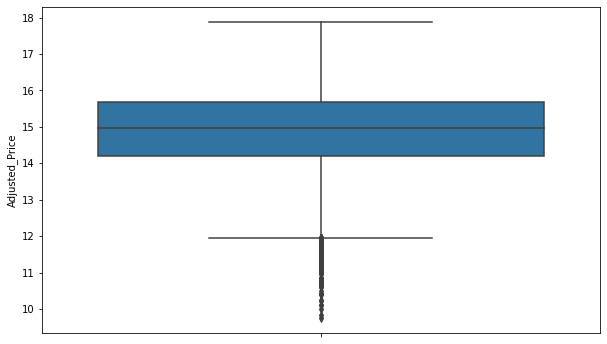

In [266]:
plt.figure(figsize=(10,6))
sns.boxplot(y= (np.log(data_inflated["Adjusted_Price"])))

plt.show()

# Missing Values

In [267]:
data_inflated.drop(data_inflated[data_inflated.loc[:, "payments"].isna()].index, inplace= True)
data_inflated.drop(data_inflated[data_inflated.loc[:, "finishes"].isna()].index, inplace= True)

# Model

In [268]:
features = data_inflated.drop(columns=["prices", "core_inflation", "CPI", "Adjusted_Price"])
features["Price_per_m"] = features["Price_per_m"] / 10000
features

,locations,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,2,4.9500,1,1,2.0,2,0,2027.0,2.0,-3.0
1,2,13.8076,1,1,2.0,2,0,2026.0,2.0,-2.0
2,1,9.5454,1,1,5.0,3,0,2025.0,2.0,-1.0
3,1,1.8333,1,1,1.0,7,0,2024.0,1.0,0.0
4,2,5.0000,1,1,2.0,2,0,2025.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
208040,2,8.0096,4,5,4.0,4,10,2025.0,3.0,-1.0
208041,3,6.1360,4,5,5.0,2,10,2027.0,3.0,-3.0
208042,2,3.6956,4,5,4.0,3,10,2016.0,1.0,8.0
208043,3,5.1515,4,5,4.0,6,10,2020.0,1.0,4.0


In [269]:
target = data_inflated["Adjusted_Price"]
target = target / 10000000
target, lambda_fitted = stats.boxcox(target) 
target

array([-1.02960891, -0.08222466, -0.8792632 , ...,  0.9218997 ,
        1.07059395,  0.40220303])

In [270]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [271]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [272]:
scaler = RobustScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)


In [273]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(
    
    objective='reg:squarederror',  # Regression task with squared error loss
    n_estimators=400,              # Number of boosting rounds
    max_depth=15,                   # Maximum depth of a tree
    random_state=42,                # Random seed for reproducibility
    n_jobs = -1,
    learning_rate=0.01,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    reg_alpha = .1,
#     reg_lambda= .1
#     colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    
)

# Train the model
model.fit(X_train, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [274]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Optionally, calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.01733987697356749
Root Mean Squared Error (RMSE): 0.13168096663363119


In [275]:
r2_score(y_test_scaled, y_pred)

0.9618610531875

In [276]:
residuals = []
for i in range(len(y_pred)):
    residuals.append(y_test_scaled[i][0] - y_pred[i])

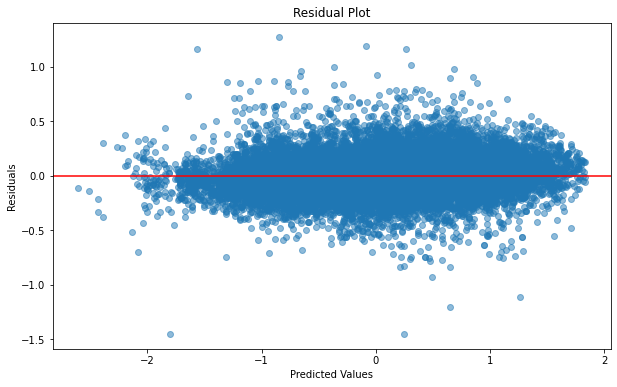

In [277]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [240]:
true_prices = data_inflated.loc[X_test.index, "prices"]

In [242]:
x= scaler.inverse_transform([y_pred])
x = inv_boxcox(x, lambda_fitted) * 10000000
x = x.reshape(-1,1)

final_pred = []
for i in range(len(x)):
    final_pred.append(x[i][0] * (data_inflated.loc[data_inflated.loc[X_test.index].index[i], "CPI"] / cpi_2024_base))

final_pred

[750911.2082478225,
 760429.3977498482,
 2420802.1917183776,
 1602227.2660593854,
 3671128.961499344,
 2731870.5015694476,
 11526648.903507989,
 623262.6752887061,
 909010.1261089299,
 3052569.1594237476,
 11873632.240621144,
 1295401.4855301287,
 1169925.1204299552,
 5073906.043829948,
 715236.8141830349,
 810405.3449058505,
 8375841.517964133,
 3152923.202160677,
 2195508.1992868003,
 1533189.4711530637,
 2524341.954190926,
 2903464.180186758,
 751968.3908400156,
 5826763.144478111,
 8259887.758272174,
 286064.95518803655,
 1365880.389699788,
 424996.59746411233,
 4398735.609016686,
 826118.1456652393,
 7618716.616121978,
 1065086.184010905,
 7816150.301477172,
 2001951.8481268943,
 9512898.242519496,
 12858974.618386997,
 711825.0834140616,
 3337324.303578457,
 12978568.37807303,
 8918133.135459589,
 492830.4133081691,
 2856820.5623414204,
 164647.23136457024,
 459900.4941918552,
 408202.2287517844,
 10706976.364991117,
 1232044.4492163248,
 1527189.994408911,
 1020200.7506424887,
 

In [278]:
residuals= []
for i in range(len(final_pred)):
    residuals.append(final_pred[i] - true_prices.values[i])
print(np.quantile(residuals, .95))
print(np.quantile(residuals, .50))
print(np.quantile(residuals, .05))

950612.7317552515
3989.2713246408966
-1742120.0944894673


In [279]:
import joblib
joblib.dump(model, 'XGBRegressor.joblib')

['XGBRegressor.joblib']